In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

pygame 2.5.2 (SDL 2.28.2, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-05-09 20:44:50.270634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 20:44:50.309115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 20:44:50.872925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device(type='cuda')

In [33]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=0,
				   eval_avg_ep_len=0,
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})

		# results = evaluate_on_env(
		# 	model=self.model, traj_dataset=self.traj_dataset,
		# 	device=self.device, context_len=self.config.context_len,
		# 	env=self.env, rtg_target=self.config.rtg_main,
		# 	num_eval_ep=self.config.num_eval_ep,
		# 	max_test_ep_len=self.config.max_eval_ep_len)
		# self.logger.log(
		# 		   model=self.model,
		# 		   loss=df['train/loss'].sum(),
		# 		   eval_avg_reward=results['eval/avg_reward'],
		# 		   eval_avg_ep_len=results['eval/avg_ep_len'],
		# 		   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
		# 		   lr=self.optimizer.param_groups[0]['lr'],
		# 		   important={"grad_norm", "lr"})
		# res = {}
		# for rtg in self.rtgs:
		# 	res[rtg] = evaluate_on_env(
		# 		model=self.model,
		# 		traj_dataset=self.traj_dataset,
		# 		device=self.device,
		# 		context_len=self.config.context_len,
		# 		env=self.env,
		# 		rtg_target=rtg,
		# 		num_eval_ep=self.config.num_eval_ep
		# 	)
		# self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_reward'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

In [58]:
from minigrid.wrappers import FlatObsWrapper, ImgObsWrapper
import gymnasium as gym

# this one does not have a wrapper
# env = ImgObsWrapper(inner_door_key_env) # wrap the environment 

inner_env = gym.make('MiniGrid-DoorKey-5x5-v0')
inner_env_human = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='human')
env = ImgObsWrapper(inner_env)
env_human = ImgObsWrapper(inner_env_human)

# to only give the vision data

# todo is this number of trajectories enough?
# todo should the reward scale be 1?
# todo make sure max_steps is not too much. we don't want the context length to be too big
traj_dataset = DoorKeyDataset(env, n_trajectories=10_000, reward_scale=1)

collecting trajectories:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 250
reward_scale: 1
return min=0.0, max=0.9532 mean=0.03393267999999999
gamma: 1


(array([149., 137., 142., 117.,  93.,  73.,  67.,  46.,  33.,   5.]),
 array([0.1    , 0.18532, 0.27064, 0.35596, 0.44128, 0.5266 , 0.61192,
        0.69724, 0.78256, 0.86788, 0.9532 ]),
 <BarContainer object of 10 artists>)

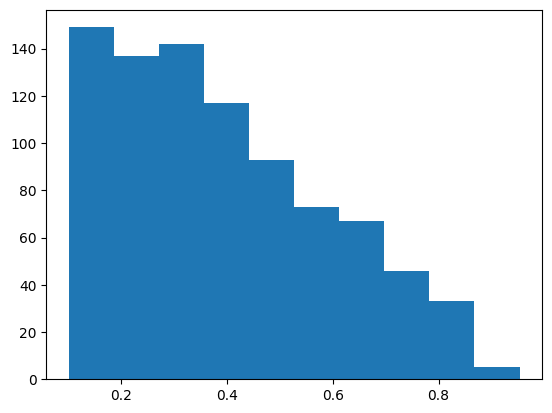

In [59]:
returns = np.array([traj.returns[0] for traj in traj_dataset])

plt.hist(returns[returns > 0])

In [60]:
# idx = np.argmax([data.returns[0] for data in traj_dataset])
# traj = traj_dataset[idx]
# 
# action_sequence = [traj_dataset.action_convertor.from_feature_space(a) for a in traj.actions]
# observation_sequence = [traj_dataset.state_convertor.from_feature_space(s) for s in traj.observations]
# 
# env = ImgObsWrapper(DoorKeyEnvSmall(render_mode='human')) # wrap the environment to only give the vision data
# obs, _ = env.reset()
# 
# # for o,a in zip(observation_sequence, action_sequence):
# # 	print(np.abs((o - obs)).max())
# # 	obs, _, _, _, _ = env.step(a)
# traj_dataset.reward_convertor.from_feature_space(traj.returns[0])

In [61]:
# env = ImgObsWrapper(DoorKeyEnvSmall(render_mode='human')) # wrap the environment to only give the vision data
# 
# env.reset()
# env.render()
# # env.reset()
# # done = False
# # ret = 0
# # while not done:
# # 	obs, reward, truncated, terminated, _ = env.step(0)
# # 	done = truncated or terminated
# # 	ret += reward
# # 	print(reward)
# # 	
# # print("return is ", ret)

In [62]:
# for a in action_sequence:
# 	
# 	env.step(a)

In [63]:
# from tqdm.notebook import tqdm
# 
# env = ImgObsWrapper(DoorKeyEnvSmall()) # wrap the environment to only give the vision data
# returns = []
# 
# def play_actions(actions):
# 	env = ImgObsWrapper(DoorKeyEnvSmall(render_mode='human')) # wrap the environment to only give the vision data
# 	obs, _ = env.reset()
# 	for action in actions:
# 		env.step(action)
# 
# 	
# for traj_i in tqdm(range(20000)):
# 	obs, _ = env.reset()
# 	ret = 0
# 	actions = []
# 	done = False
# 	while not done:
# 		action = env.action_space.sample()
# 		obs, reward, terminated, truncated, info = env.step(action)
# 		done = truncated or terminated
# 		ret += reward
# 		actions.append(action)
# 	if ret > 0:
# 		break

In [64]:
# env = ImgObsWrapper(DoorKeyEnvSmall(render_mode='human')) # wrap the environment to only give the vision data
# obs, _ = env.reset()
# for action in actions:
# 	env.step(action)
# # actions

In [65]:
# todo rtg_range_check and rtg_main are used for plotting and monitoring
# todo is the rtg_range_check correct?
config = TrainConfig(max_eval_ep_len=100, context_len=64, rtg_range_check=(0, 1), rtg_main=5)

experiment_name = '5x5-easy-doorkey-dataset-size=10000'

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

number of parameters 1159579


In [86]:
config = TrainConfig(max_eval_ep_len=100, context_len=64, rtg_range_check=(0, 1), rtg_main=5,
					 
					 # change this in the future. 1000 is too much
					 max_train_iters=1000)


trainer = TrainerDT(name=experiment_name, model=model,
					optimizer=optimizer, loss_fn=loss_fn,
					dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
					device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)


In [87]:
report = trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

achieved average reward:  0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_5x5-easy-doorkey-dataset-size=10000_model_24-05-09-23-40-31_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_5x5-easy-doorkey-dataset-size=10000_model_24-05-09-23-40-31.pt
time elapsed: 0:00:02
num of updates: 100
loss: 12.01296
eval avg reward: 0.00000
best score: -inf
eval_avg_ep_len 0.00000
grad_norm 0.00395
lr 0.00100
achieved average reward:  0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_5x5-easy-doorkey-dataset-size=10000_model_24-05-09-23-40-31_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_5x5-easy-doorkey-dataset-size=10000_model_24-05-09-23-40-31.pt
time elapsed: 0:00:04
num of updates: 200
loss: 12.01705
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 0.00000
grad_norm 0.00585
lr

In [88]:
# callback.plot_eval_results()

[autoreload of algorithms.random_policy failed: Traceback (most recent call last):
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packag

<Axes: >

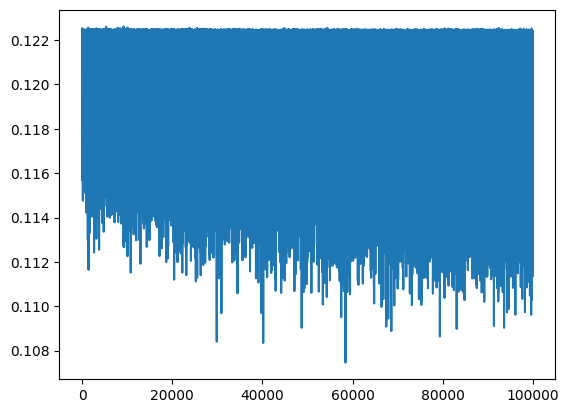

In [89]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

  0%|          | 0/30 [00:00<?, ?it/s]

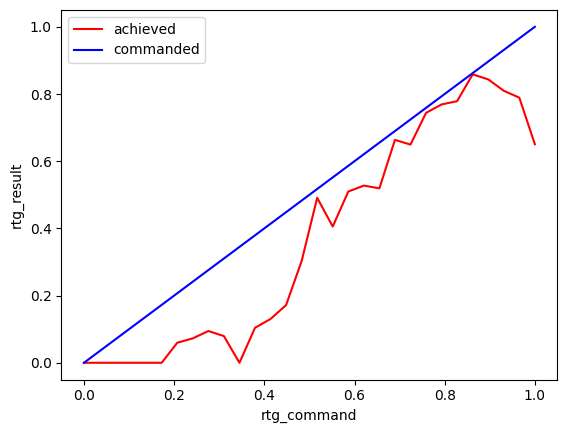

In [90]:
from tqdm.notebook import tqdm

rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in tqdm(rtg_command):
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


# import networkx as nx
# 
# shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
# best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(shortest_path[:-1], shortest_path[1:]))
# 
# plt.hlines(best_score, config.rtg_range_check[0], config.rtg_range_check[1])

plt.legend(["achieved", "commanded", "best"])


In [96]:
# watch!
rtg_target = 0.9

res = evaluate_on_env(
	model=model,
	traj_dataset=traj_dataset,
	device=device,
	context_len=config.context_len,
	env=env_human,
	rtg_target=rtg_target,
	num_eval_ep=10
)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [94]:
env.close()